In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch
import segmentation_models_pytorch as smp
import matplotlib
import scipy
from segmentation_models_pytorch import utils as smp_utils
import pandas as pd
from os.path import exists
from natsort import natsorted
import pandas as pd

In [6]:
# calcium = pd.read_csv(r'ele_cons/Calcium.csv', header=None)
# calcium = np.reshape(calcium.to_numpy(), (125, 1))
# calcium = np.repeat(calcium, 5)
# calcium.shape

(625,)

In [8]:
# sem_ids = os.listdir('train')
# sem_ids.sort()
# sem_ids = natsorted(sem_ids)
# sem_ids

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
# abspath = os.path.abspath(__file__)
# dname = os.path.dirname(abspath)
# print('Current directory:', dname)
# os.chdir(dname)

In [4]:
DATA_DIR = './'

In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_annot')

x_valid_dir = os.path.join(DATA_DIR, 'train')
y_valid_dir = os.path.join(DATA_DIR, 'train_annot')

x_test_dir = os.path.join(DATA_DIR, 'train')
y_test_dir = os.path.join(DATA_DIR, 'train_annot')

In [6]:
# helper function for data visualization
def visualize(image, mask):
    """PLot images in one row."""
    n = mask.shape[2]+1
    plt.figure(figsize=(n*6, 5))
    # for i, (name, image) in enumerate(images.items()):

    plt.subplot(1, n, 1)
    plt.xticks([])
    plt.yticks([])
    # plt.title(' '.join(name.split('_')).title())
    plt.imshow(image)
    
    cmaps = [
        matplotlib.colors.ListedColormap(['black', 'red']),
        matplotlib.colors.ListedColormap(['black', 'orange']),
        matplotlib.colors.ListedColormap(['black', 'blue']),
        matplotlib.colors.ListedColormap(['black', 'pink']),
        matplotlib.colors.ListedColormap(['black', 'green']),
        matplotlib.colors.ListedColormap(['black', 'yellow']),
        matplotlib.colors.ListedColormap(['black', 'red']),
    ]
    names = ['C', 'Ca', 'Mg', 'Na', 'O', 'S', 'Cl']
    
    for j in range(7):
        plt.subplot(1, n, j + 2)
        plt.xticks([])
        plt.yticks([])
        name = names[j]
        plt.title(name)
        plt.imshow(mask[:, :, j], cmap = cmaps[j], vmin=0, vmax=1)
    plt.show()

In [7]:
class Dataset(BaseDataset):
    """Setup Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.
    """

    def __init__(self, images_dir, masks_dir, augmentation=None, preprocessing=None):
        # list file names in the self.ids list
        self.sem_ids = os.listdir(images_dir)
        self.label_ids = os.listdir(masks_dir)
        
        self.sem_ids.sort()
        self.label_ids.sort()
        
        if self.sem_ids[0].startswith('.'):
            self.sem_ids.pop(0)
            
        if self.label_ids[0].startswith('.'):
            self.label_ids.pop(0)
        
        self.sem_ids = natsorted(self.sem_ids)
        self.label_ids = natsorted(self.label_ids)
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.sem_ids]
        self.masks_fps = [os.path.join(masks_dir, label_id) for label_id in self.label_ids]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        # print(image.shape)
        # converting the file dimension in [N, C, H, W] order
        # image = np.transpose(image, (2, 0, 1))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mat = scipy.io.loadmat(self.masks_fps[i])
        mask = mat['label']
        mask = np.transpose(mask, (1, 2, 0))
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.sem_ids)

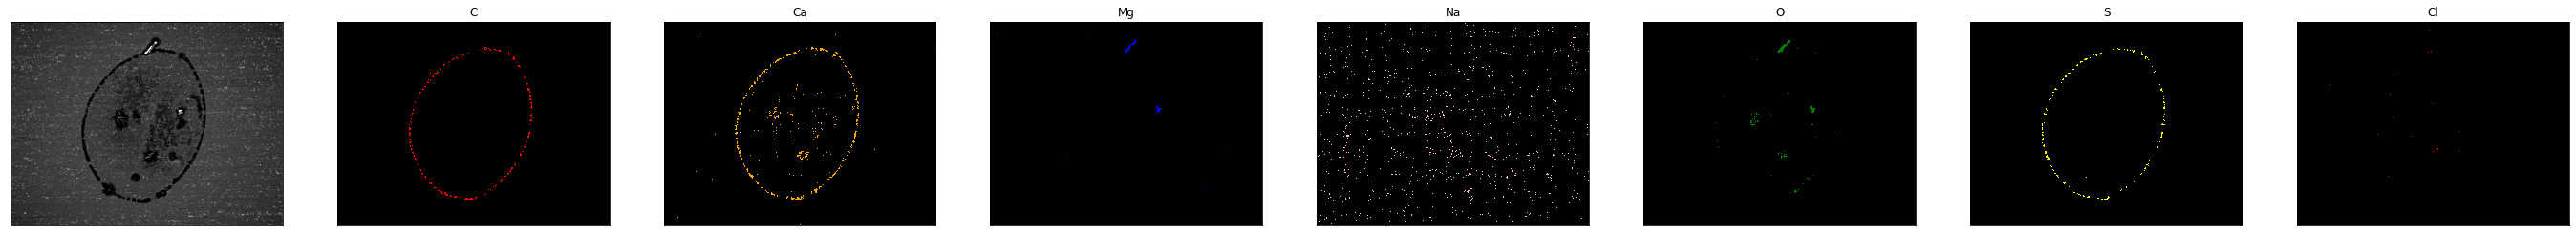

In [8]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir)
image, mask = dataset[5]
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [9]:
def get_training_augmentation():
    
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        # albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.GaussNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                # albu.RandomBrightness(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.IAASharpen(p=1),
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.RandomContrast(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

In [10]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

(1920, 2560, 3) (1920, 2560, 7)


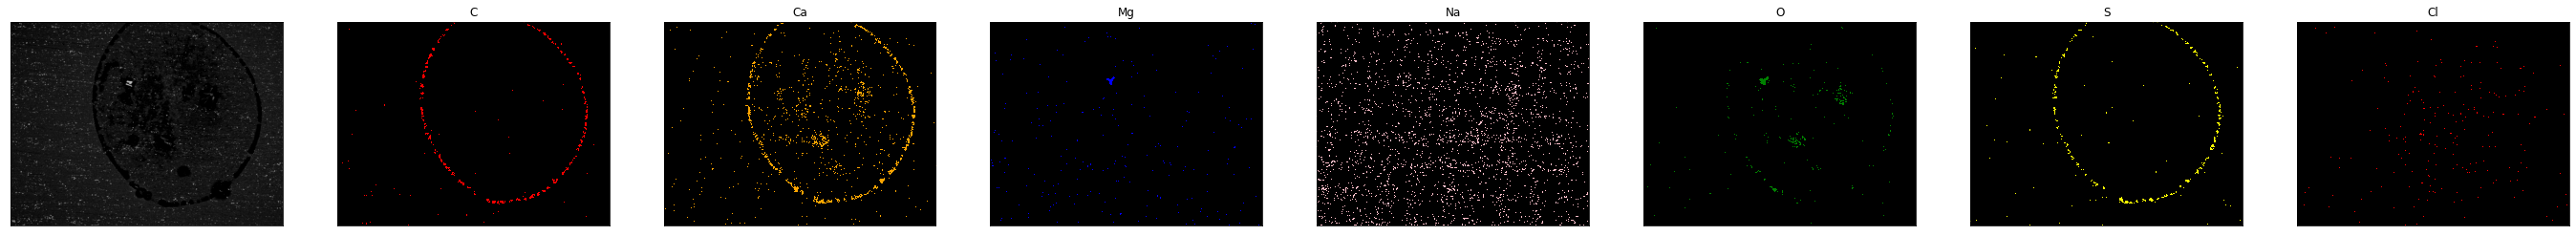

In [11]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
)
image, mask = augmented_dataset[5]
print(image.shape, mask.shape)
visualize(image=image, mask=mask)

In [12]:
torch.cuda.empty_cache()
# torch.cuda.set_per_process_memory_fraction(0.9, 0)

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

In [13]:
model = smp.Unet(
    encoder_name="resnet34", 
    encoder_weights='imagenet',
    classes = 7, 
    activation='sigmoid'
)

file_exists = exists('best_model.pth')
# if file_exists:
#     model = torch.load('./best_model.pth')
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [14]:
print(type(model))

<class 'segmentation_models_pytorch.decoders.unet.model.Unet'>


In [15]:
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [16]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

In [17]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

test_dataloader = DataLoader(test_dataset)

In [18]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0)

In [20]:
loss = smp.losses.DiceLoss("multilabel")
loss.__name__ = 'Dice_loss'

metrics = [
    smp_utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

In [21]:
train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True
)

valid_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True
)

In [22]:
max_score = 0

#################################
n = np.random.choice(len(train_dataset))

train_dataset_vis = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

In [23]:
# image_vis = train_dataset_vis[n][0].astype('uint8')
# image, gt_mask = train_dataset[n]

# gt_mask = gt_mask.squeeze()

# x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

# pr_mask = model.predict(x_tensor)
# pr_mask = (pr_mask.squeeze().cpu().numpy().round())

In [24]:
best_model = torch.load('./best_model.pth')


Epoch: 0
valid: 100%|██████████| 157/157 [08:38<00:00,  3.30s/it, Dice_loss - 0.8535, iou_score - 0.09568]
Model saved!


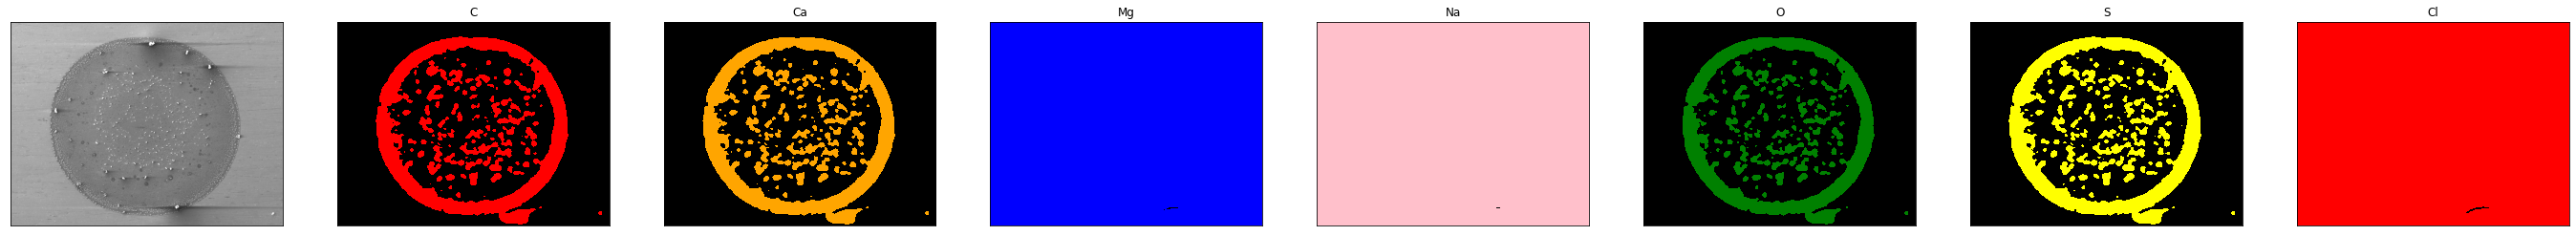


Epoch: 1
train:  89%|████████▉ | 140/157 [12:26<01:30,  5.33s/it, Dice_loss - 0.8617, iou_score - 0.09993]


KeyboardInterrupt: 

In [25]:
for i in range(0, 1000):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        # print('Iou score:', max_score)
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
        
    # if i % 5 == 0:
    #     n = np.random.choice(len(test_dataset))
    #     image_vis = test_dataset_vis[n][0].astype('uint8')
    #     image, gt_mask = test_dataset[n]
    #     image = np.transpose(image, (2, 0, 1))
    #     gt_mask = gt_mask.squeeze()
    #     x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    #     x_tensor = x_tensor.float()
    #     best_model = torch.load('./best_model.pth')
    #     pr_mask = best_model.predict(x_tensor)
    #     pr_mask = pr_mask.squeeze().cpu().numpy().round()
    #     pr_mask = np.transpose(pr_mask, (1, 2, 0))
    #     print(image.shape, pr_mask.shape)
    #     visualize(
    #         image=image_vis, 
    #         mask=pr_mask
    #     )
    if i % 5 == 0:
        n = np.random.choice(len(test_dataset))
        image_vis = test_dataset_vis[n][0].astype('uint8')
        image, gt_mask = test_dataset[n]
        gt_mask = gt_mask.squeeze()
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        best_model = torch.load('./best_model.pth')
        pr_mask = model.predict(x_tensor)
        pr_mask = pr_mask.squeeze().cpu().numpy().round()
        pr_mask = np.transpose(pr_mask, (1, 2, 0))
        visualize(
            image=image_vis, 
            mask=pr_mask
        )

In [ ]:
EDS_predict_path = 'EDS_predict_path'

try: 
    os.mkdir(EDS_predict_path)
except OSError as error: 
    print(error)  

EDS_train_dir = os.path.join(DATA_DIR, 'EDS_predict_path')

In [ ]:
# for i in range(len(test_dataset)):
for i in range(5):
    for j in range(25):
        for k in range(5):
            image, gt_mask = test_dataset[i]
            image = np.transpose(image, (2, 0, 1))
            gt_mask = gt_mask.squeeze()
            x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
            x_tensor = x_tensor.float()
            pr_mask = best_model.predict(x_tensor)
            pr_mask = pr_mask.squeeze().cpu().numpy().round()
            image = np.transpose(image, (1, 2, 0))
            pr_mask = np.transpose(pr_mask, (1, 2, 0))
            image_mask = np.concatenate((image, pr_mask), axis=2)
            np.save(EDS_predict_path+'/'+str(i)+'_'+str(j)+'_'+str(k)+'.npy', image_mask)

In [ ]:
for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['accuracy']:
        max_score = valid_logs['accuracy']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
        
    if i % 10 == 0:
        n = np.random.choice(len(test_dataset))
        image_vis = test_dataset_vis[n][0].astype('uint8')
        image, gt_mask = test_dataset[n]
        gt_mask = gt_mask.squeeze()
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        pr_mask = best_model.predict(x_tensor)
        pr_mask = pr_mask.squeeze().cpu().numpy().round()
        pr_mask = np.transpose(pr_mask, (1, 2, 0))
        visualize(
            image=image_vis, 
            mask=pr_mask
        )

In [ ]:
# evaluate model on test set
test_epoch = smp_utils.train.ValidEpoch(
    model='best_model.pth',
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

In [ ]:
logs = test_epoch.run(test_dataloader)

In [ ]:
calcium = pd.read_csv(r'ele_cons/Calcium.csv', header=None)
carbon = pd.read_csv(r'ele_cons/Carbon.csv', header=None)
chlorine = pd.read_csv(r'ele_cons/Chlorine.csv', header=None)
magnesium = pd.read_csv(r'ele_cons/Magnesium.csv', header=None)
oxygen = pd.read_csv(r'ele_cons/Oxygen.csv', header=None)
sodium = pd.read_csv(r'ele_cons/Sodium.csv', header=None)
sulphur = pd.read_csv(r'ele_cons/Sulphur.csv', header=None)

In [ ]:
calcium = np.reshape(calcium.to_numpy(), (125, 1))
carbon = np.reshape(carbon.to_numpy(), (125, 1))
chlorine = np.reshape(chlorine.to_numpy(), (125, 1))
magnesium = np.reshape(magnesium.to_numpy(), (125, 1))
oxygen = np.reshape(oxygen.to_numpy(), (125, 1))
sodium = np.reshape(sodium.to_numpy(), (125, 1))
sulphur = np.reshape(sulphur.to_numpy(), (125, 1))

In [ ]:
calcium = np.repeat(calcium, 5)
carbon = np.repeat(carbon, 5)
chlorine = np.repeat(chlorine, 5)
magnesium = np.repeat(magnesium, 5)
oxygen = np.repeat(oxygen, 5)
sodium = np.repeat(sodium, 5)
sulphur = np.repeat(sulphur, 5)

In [ ]:
calcium = np.reshape(calcium, (625, 1))
carbon = np.reshape(carbon, (625, 1))
chlorine = np.reshape(chlorine, (625, 1))
magnesium = np.reshape(magnesium, (625, 1))
oxygen = np.reshape(oxygen, (625, 1))
sodium = np.reshape(sodium, (625, 1))
sulphur = np.reshape(sulphur, (625, 1))

In [ ]:
elements = np.concatenate((calcium, carbon, chlorine, magnesium, oxygen, sodium, sulphur), axis=1)

In [ ]:
import torch
import torch.nn.functional as F
# from utils import MyTrainDataset

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

In [ ]:
MyTrainDataset = train_dataset

In [ ]:
def ddp_setup(rank, world_size):
    """
    Args:
        rank: Unique identifier of each process
        world_size: Total number of processes
    """
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"
    init_process_group(backend="nccl", rank=rank, world_size=world_size)

In [ ]:
class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_data: DataLoader,
        optimizer: torch.optim.Optimizer,
        gpu_id: int,
        save_every: int,
    ) -> None:
        self.gpu_id = gpu_id
        self.model = model.to(gpu_id)
        self.train_data = train_data
        self.optimizer = optimizer
        self.save_every = save_every
        self.model = DDP(model, device_ids=[gpu_id])

    def _run_batch(self, source, targets):
        self.optimizer.zero_grad()
        output = self.model(source)
        loss = F.cross_entropy(output, targets)
        loss.backward()
        self.optimizer.step()

    def _run_epoch(self, epoch):
        b_sz = len(next(iter(self.train_data))[0])
        print(f"[GPU{self.gpu_id}] Epoch {epoch} | Batchsize: {b_sz} | Steps: {len(self.train_data)}")
        self.train_data.sampler.set_epoch(epoch)
        for source, targets in self.train_data:
            source = source.to(self.gpu_id)
            targets = targets.to(self.gpu_id)
            self._run_batch(source, targets)

    def _save_checkpoint(self, epoch):
        ckp = self.model.module.state_dict()
        PATH = "checkpoint.pt"
        torch.save(ckp, PATH)
        print(f"Epoch {epoch} | Training checkpoint saved at {PATH}")

    def train(self, max_epochs: int):
        for epoch in range(max_epochs):
            self._run_epoch(epoch)
            if self.gpu_id == 0 and epoch % self.save_every == 0:
                self._save_checkpoint(epoch)

In [ ]:
dataset = 

In [ ]:
model = 

In [ ]:
def load_train_objs():
    train_set = MyTrainDataset(2048)  # load your dataset
    model = torch.nn.Linear(20, 1)  # load your model
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    return train_set, model, optimizer

In [ ]:
def prepare_dataloader(dataset: Dataset, batch_size: int):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        sampler=DistributedSampler(dataset)
    )

In [ ]:
def main(rank: int, world_size: int, save_every: int, total_epochs: int, batch_size: int):
    ddp_setup(rank, world_size)
    dataset, model, optimizer = load_train_objs()
    train_data = prepare_dataloader(dataset, batch_size)
    trainer = Trainer(model, train_data, optimizer, rank, save_every)
    trainer.train(total_epochs)
    destroy_process_group()

In [ ]:
# if __name__ == "__main__":
# import argparse
# parser = argparse.ArgumentParser(description='simple distributed training job')
# parser.add_argument('total_epochs', type=int, help='Total epochs to train the model')
# parser.add_argument('save_every', type=int, help='How often to save a snapshot')
# parser.add_argument('--batch_size', default=32, type=int, help='Input batch size on each device (default: 32)')
# args = parser.parse_args()

world_size = torch.cuda.device_count()
print(world_size)
mp.spawn(main, args=(world_size, 10, 1000, 4), nprocs=world_size)